In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import load_model
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import plot_model
from tqdm import tqdm

Using TensorFlow backend.


## Function for displaying images with predicted bounding box

In [2]:
def show_img_with_rect_pred_only(img, lab_pred, col_pred, figsize=None, fig_num=None):
    x1p = int(lab_pred[0])
    x2p = int(lab_pred[1])
    y1p = int(lab_pred[2])
    y2p = int(lab_pred[3])
    cv2.putText(img, 'pred', (x1p, y1p), cv2.FONT_HERSHEY_SIMPLEX, 1.0, col_pred, lineType=cv2.LINE_AA)
    cv2.rectangle(img,(x1p,y1p),(x2p,y2p),col_pred,2) # (0,255,0)
    if figsize != None and fig_num != None:
        plt.figure(fig_num, figsize=figsize)
    elif figsize != None and fig_num == None:
        plt.figure(figsize=figsize)
    elif figsize == None and fig_num != None:
        plt.figure(fig_num)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
def show_img_with_rect(img, lab_pred, lab_true, col_true, col_pred, figsize=None):
    x1t = int(lab_true[0])
    x2t = int(lab_true[1])
    y1t = int(lab_true[2])
    y2t = int(lab_true[3])
    x1p = int(lab_pred[0])
    x2p = int(lab_pred[1])
    y1p = int(lab_pred[2])
    y2p = int(lab_pred[3])
    cv2.putText(img, 'true', (x1t, y1t), cv2.FONT_HERSHEY_SIMPLEX, 1.0, col_true, lineType=cv2.LINE_AA)
    cv2.putText(img, 'pred', (x2p, y2p), cv2.FONT_HERSHEY_SIMPLEX, 1.0, col_pred, lineType=cv2.LINE_AA)
    cv2.rectangle(img,(x1t,y1t),(x2t,y2t),col_true,2) # (0,255,0)
    cv2.rectangle(img,(x1p,y1p),(x2p,y2p),col_pred,2) # (0,255,0)
    if figsize != None:
        plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
def mIoU(labels,predictions):
    pred_x1=predictions[:,0]
    pred_x2=predictions[:,1]
    pred_y1=predictions[:,2]
    pred_y2=predictions[:,3]
    label_x1=labels[:,0]
    label_x2=labels[:,1]
    label_y1=labels[:,2]
    label_y2=labels[:,3]
    int_x1 = tf.maximum(pred_x1, label_x1)
    int_x2 = tf.minimum(pred_x2, label_x2)
    int_y1 = tf.maximum(pred_y1, label_y1)
    int_y2 = tf.minimum(pred_y2, label_y2)
    tensor_type = pred_x1.dtype
    pred_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), pred_x2 - pred_x1), tf.maximum(tf.cast(0.0, tensor_type), pred_y2 - pred_y1))
    label_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), label_x2 - label_x1), tf.maximum(tf.cast(0.0, tensor_type), label_y2 - label_y1))
    int_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), int_x2 - int_x1), tf.maximum(tf.cast(0.0, tensor_type), int_y2 - int_y1))
    union_area = pred_area + label_area - int_area
    IoU = int_area / union_area
    return tf.reduce_mean(IoU)

In [4]:
orig_img_dir = './Data/images'
base_dir = '.'
test_df_dir = './Data/test_s3.csv'
test_df = pd.read_csv(test_df_dir)
s3_img_dir = orig_img_dir

In [5]:
print(len(test_df))
test_df.tail()

1470


image_name   x1   x2  y1   y2
1465     JPEG_20160318_162415_1770951624.png   98  497  79  406
1466      1478951045742eMazingShawls3713.png   28  584  45  362
1467        147754103737320161026_131623.png   95  474  91  346
1468        147772054797120161028_170500.png   48  527  96  456
1469  JPEG_20161209_143913_1000223341099.png  138  531  11  436

In [6]:
model = load_model('./chkpts/xception_lrf_training_s3_mix.h5', custom_objects = {'mIoU':mIoU})

In [7]:
df = test_df.copy()
df.drop(['x1', 'x2', 'y1', 'y2'], axis = 1, inplace = True)
df.head()

image_name
0  JPEG_20161126_162623_1000546658770.png
1               1481270150585DSC_0717.png
2               1480315379337_R2A3008.png
3  JPEG_20160625_154820_1000567719062.png
4               1473750801552IMG_1035.png

In [11]:
p_true = test_df[['x1', 'x2', 'y1', 'y2']].values
p_true[:2]

array([[ 75, 482, 183, 357],
       [  0, 590,  76, 440]], dtype=int64)

In [12]:
preds = []
im_list = []
for im in tqdm(test_df.image_name):
    img = cv2.imread(os.path.join(s3_img_dir, im))
    img = cv2.resize(img, (299, 299))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    preds.append(pred)
    im_list.append(im)
    
p = np.vstack(preds)


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:42<00:00, 34.71it/s]


In [13]:
p[:2]

array([[ 97.43419, 488.58582, 194.4058 , 355.7124 ],
       [  0.     , 596.6503 ,  73.54709, 436.87912]], dtype=float32)

In [14]:
p_true[:2]

array([[ 75, 482, 183, 357],
       [  0, 590,  76, 440]], dtype=int64)

## Prediction on a random example

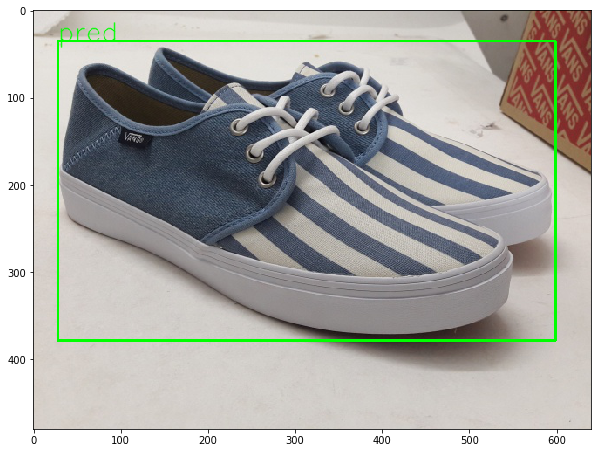

In [68]:
im_num = 16112
im = test_df.image_name[im_num]
show_img_with_rect_pred_only(cv2.imread(os.path.join(s3_img_dir, im)),
                             lab_pred=p[im_num],
                             col_pred=(0, 255, 0),
                             figsize=(10, 10))

## Prediction on a set of 25 random images

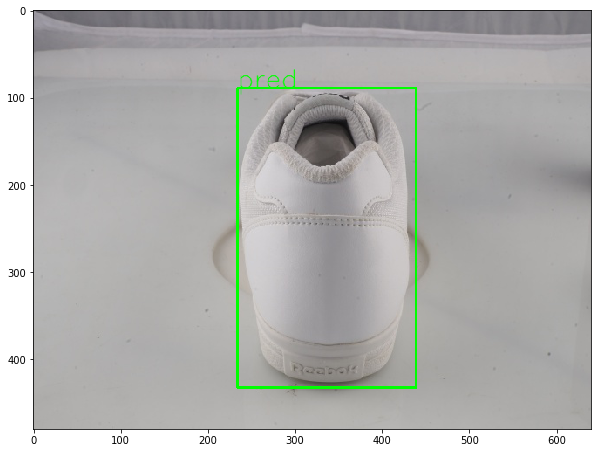

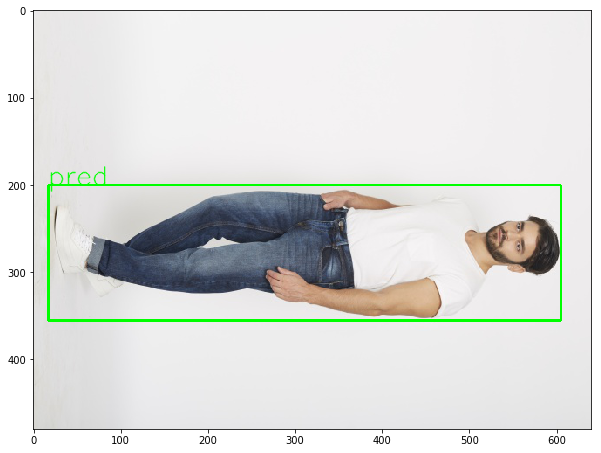

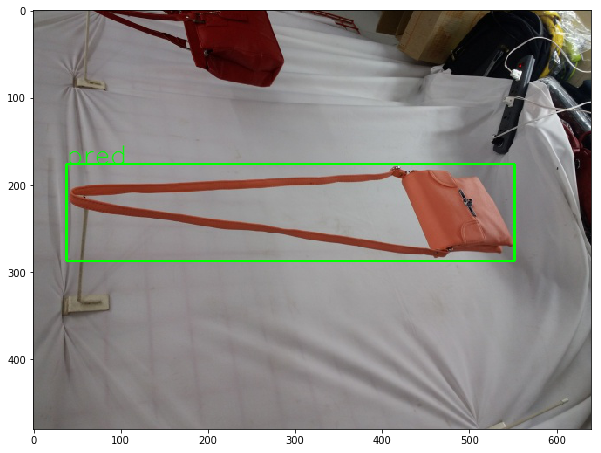

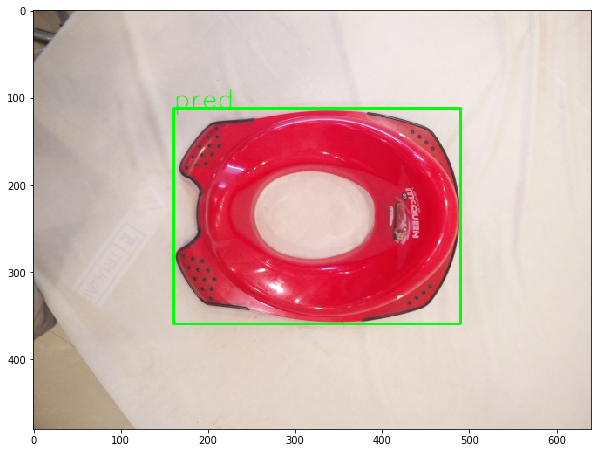

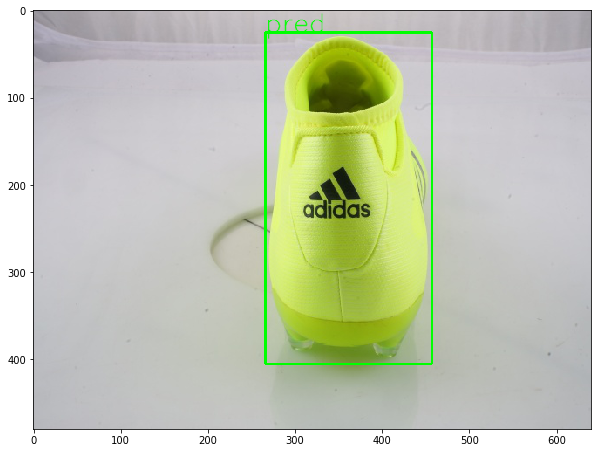

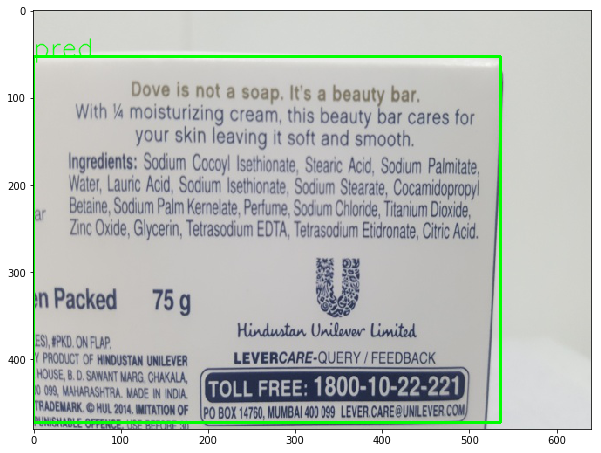

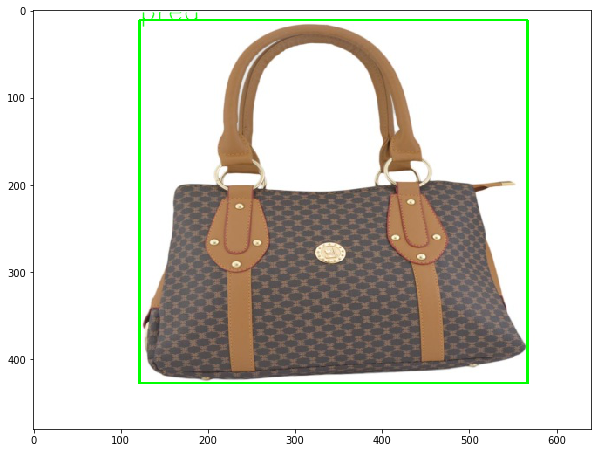

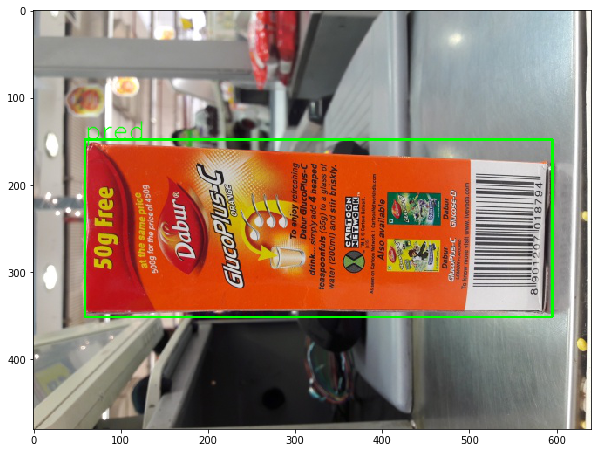

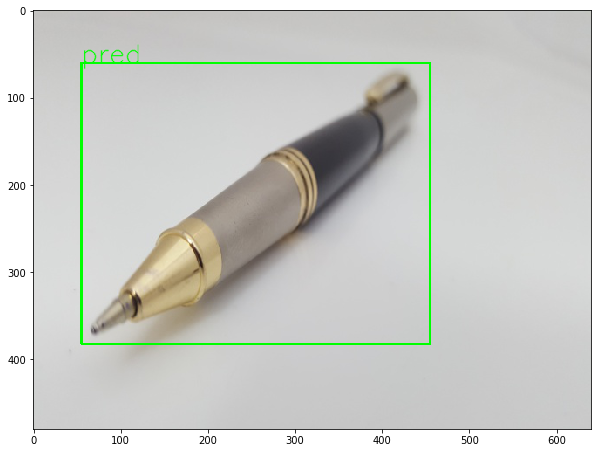

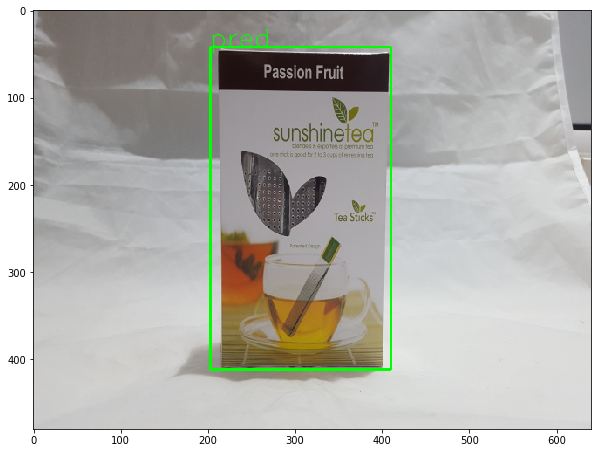

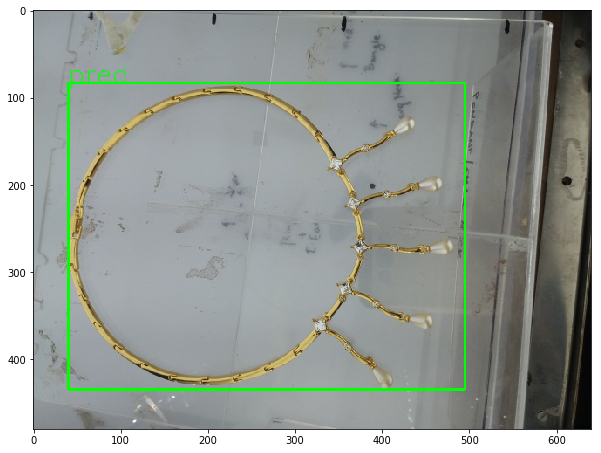

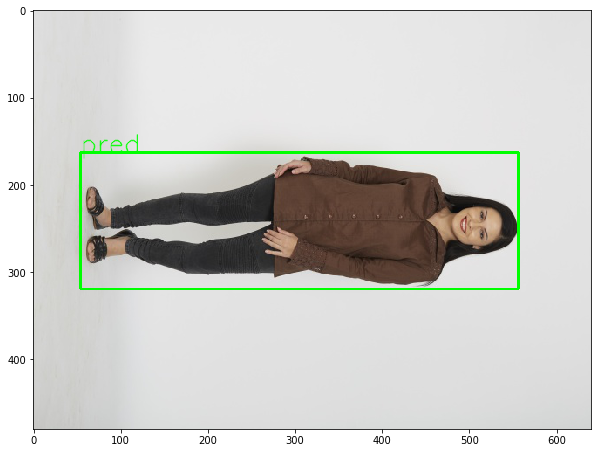

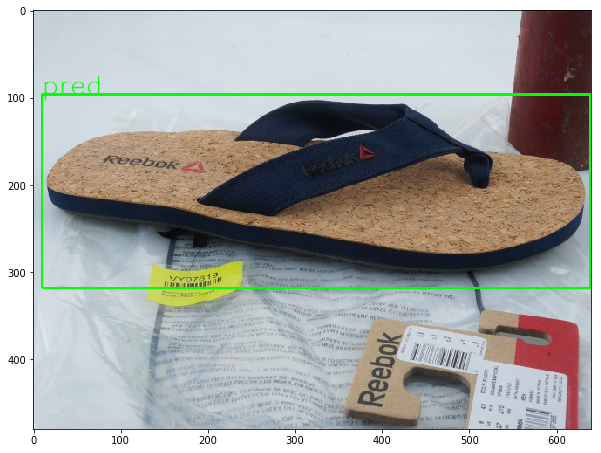

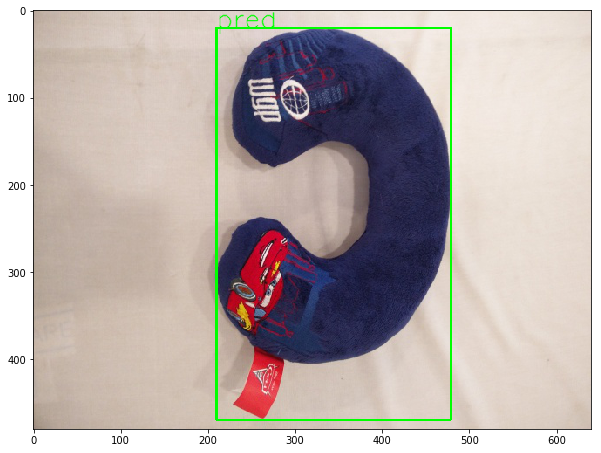

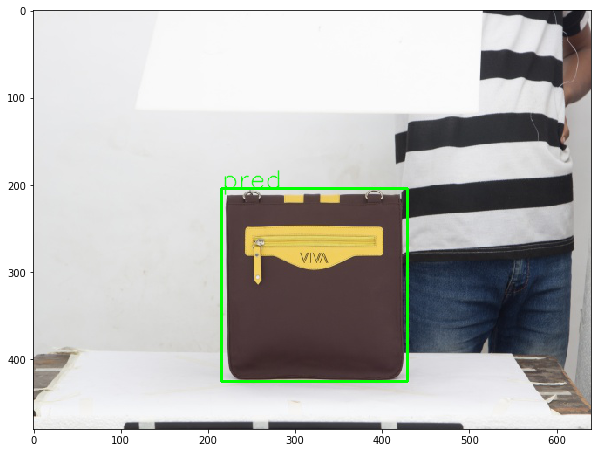

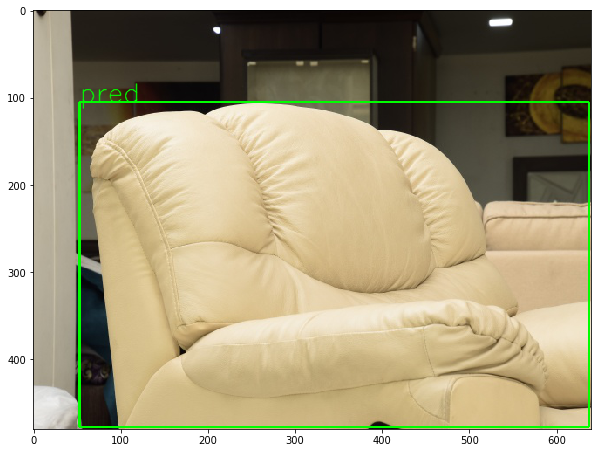

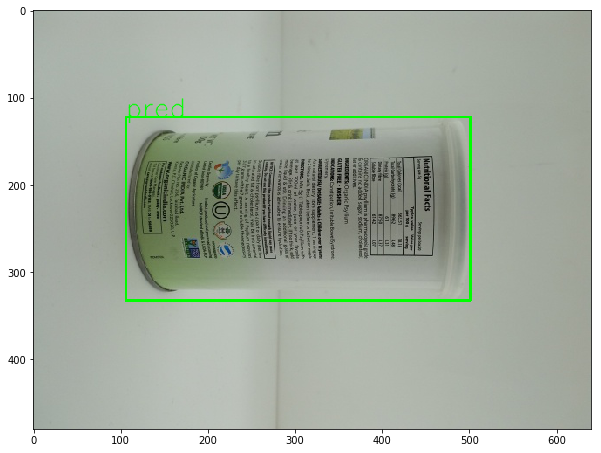

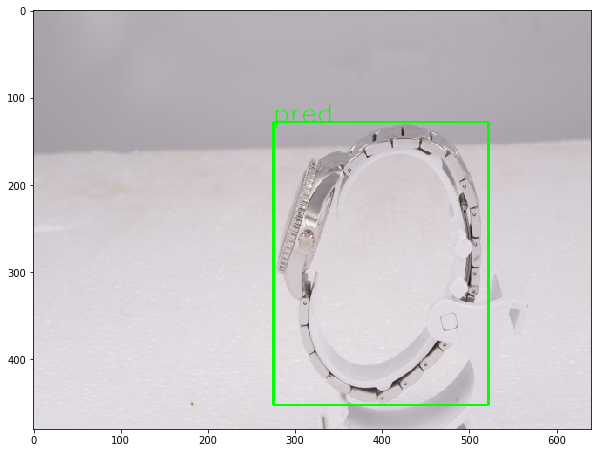

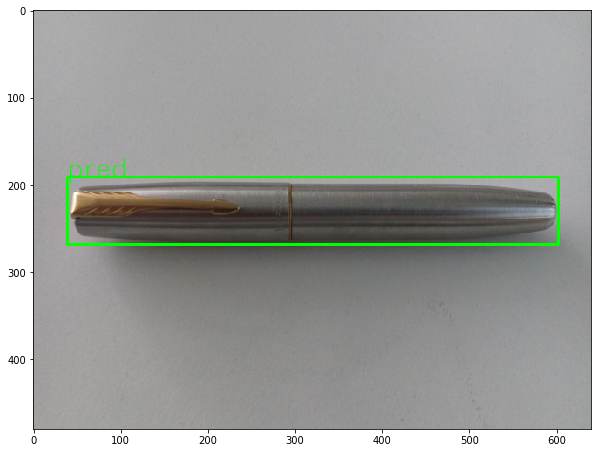

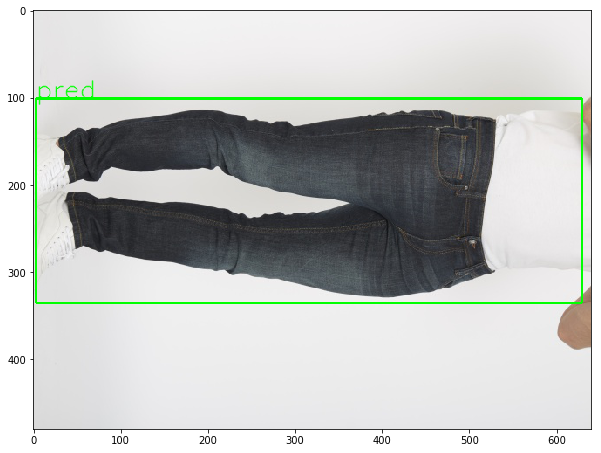

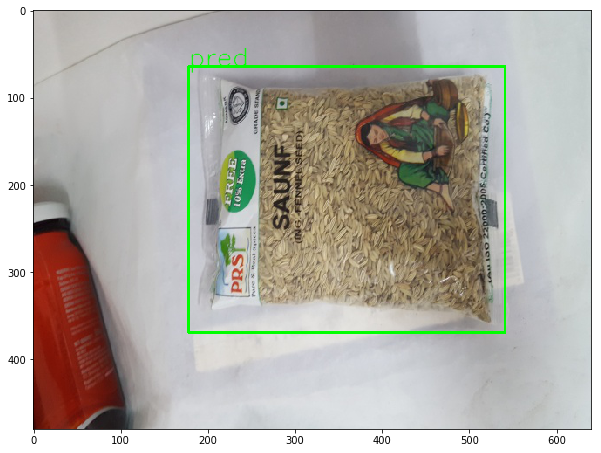

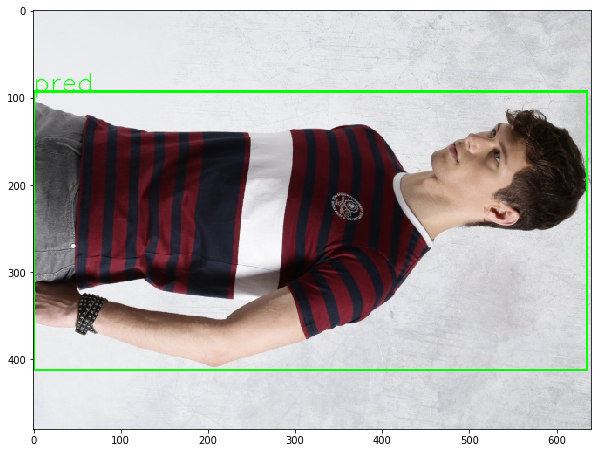

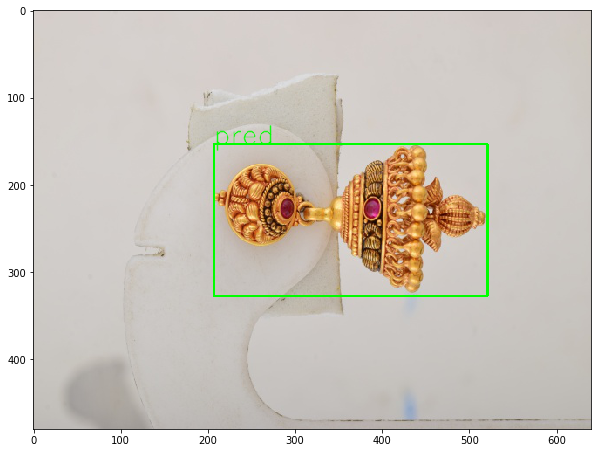

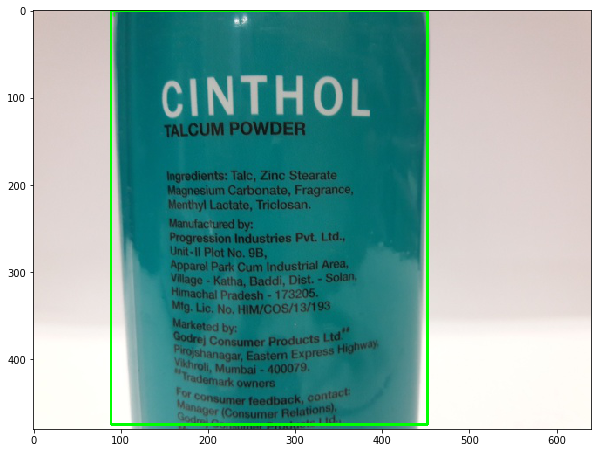

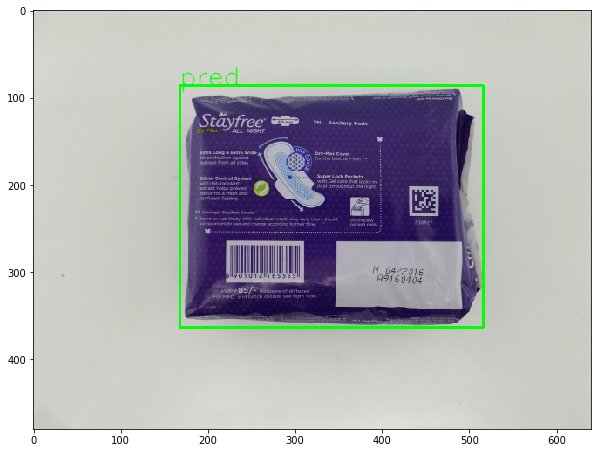

In [72]:
import random
for i in range(25):
    im_num = random.randint(0, 24044)
    im = test_df.image_name[im_num]
    show_img_with_rect_pred_only(cv2.imread(os.path.join(s3_img_dir, im)),
                             lab_pred=p[im_num],
                             col_pred=(0, 255, 0),
                             figsize=(10, 10), fig_num=i)

In [ ]:
test_df[['x1', 'x2', 'y1', 'y2']] = p

In [ ]:
test_df.to_csv(os.path.join('.', 'submission.csv'), index = False)